### Import sdk

In [1]:
import os
os.chdir("/home/ma-user/work/kpi_feature")
from naie.context import Context as context
from naie.datasets import data_reference
from naie.feature_processing import data_flow
from naie.feature_analysis import data_analysis
from naie.feature_processing.expression import col, cols, cond, f_and, f_not, f_or
from naie.common.data.typedefinition import StepType, ColumnRelationship, JoinType, ColumnSelector,DynamicColumnsSelectorDetails, StaticColumnsSelectorDetails, ColumnsSelectorDetails, DataProcessMode
from naie.common.display import display

INFO:root:Using MoXing-v1.16.4-4e3b3168
INFO:root:Using OBS-Python-SDK-3.1.2
INFO:root:Successfully apply patch MoXingPatchRemoveAKSK.py


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from  datetime import datetime
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',150)

## 选择数据

In [3]:
from naie.datasets import data_reference
df_train=data_reference.get_data_reference(dataset="DatasetService",dataset_entity="learning_competition_train_data").to_pandas_dataframe()
df_test=data_reference.get_data_reference(dataset="DatasetService",dataset_entity="learning_competition_test_data").to_pandas_dataframe()

resolve path s3://bucket-ebe3fox4/0548d3aef88010d81fe5c01705849a10/ceba8dd9005f4849a86773743085160b/Dataset DatasetService learning_competition_train_data.
transform dataUrl from s3://bucket-ebe3fox4/0548d3aef88010d81fe5c01705849a10/ceba8dd9005f4849a86773743085160b/Dataset to s3://bucket-ebe3fox4/0548d3aef88010d81fe5c01705849a10/Dataset.
resolve dataPath to s3://bucket-er6o954w/ServiceTmpData/DataCatlog/Download/usstroot/usstroot/Dataset/.
resolve path s3://bucket-ebe3fox4/0548d3aef88010d81fe5c01705849a10/ceba8dd9005f4849a86773743085160b/Dataset DatasetService learning_competition_test_data.
transform dataUrl from s3://bucket-ebe3fox4/0548d3aef88010d81fe5c01705849a10/ceba8dd9005f4849a86773743085160b/Dataset to s3://bucket-ebe3fox4/0548d3aef88010d81fe5c01705849a10/Dataset.
resolve dataPath to s3://bucket-er6o954w/ServiceTmpData/DataCatlog/Download/usstroot/usstroot/Dataset/.


In [4]:
df_train.head()

,start_time,value,label,kpi
0,2018/12/16 0:00,392,0,Number of Answered Sessions After Domain Selec...
1,2018/12/16 1:00,188,0,Number of Answered Sessions After Domain Selec...
2,2018/12/16 2:00,97,0,Number of Answered Sessions After Domain Selec...
3,2018/12/16 3:00,68,0,Number of Answered Sessions After Domain Selec...
4,2018/12/16 4:00,60,0,Number of Answered Sessions After Domain Selec...


In [5]:
df = pd.concat([df_train,df_test])
df = df.reset_index()

### 转换为标准时间格式并提取时间特征

In [6]:
df['start_time']=pd.to_datetime(df['start_time'])

In [7]:
df['weekday']=df['start_time'].dt.weekday
df['hour']=df['start_time'].dt.hour
df['weekend']=(df['weekday']>5).astype(int)
df['daylight']=((df['hour'] >= 20) | (df['hour'] <= 7)).astype(int)

In [8]:
df['value']=pd.to_numeric(df['value'],errors='coerce')
df['value']=df['value'].fillna(method='bfill')

## 可视化

In [9]:
#把ID特征转换为数值型
le=LabelEncoder()
df['kpi_id']=le.fit_transform(df['kpi'])

### 正负样本比例

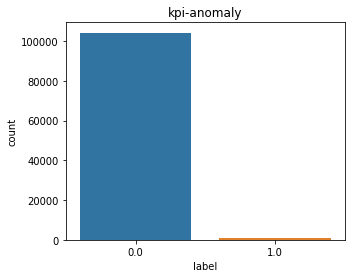

In [11]:
fig=plt.figure(figsize=(5,4))
fig=sns.countplot(df.label)
fig=plt.title("kpi-anomaly")

In [14]:
pd.crosstab(df.label, "count")

col_0,count
label,
0.0,104258
1.0,1006


### 异常时间点分布

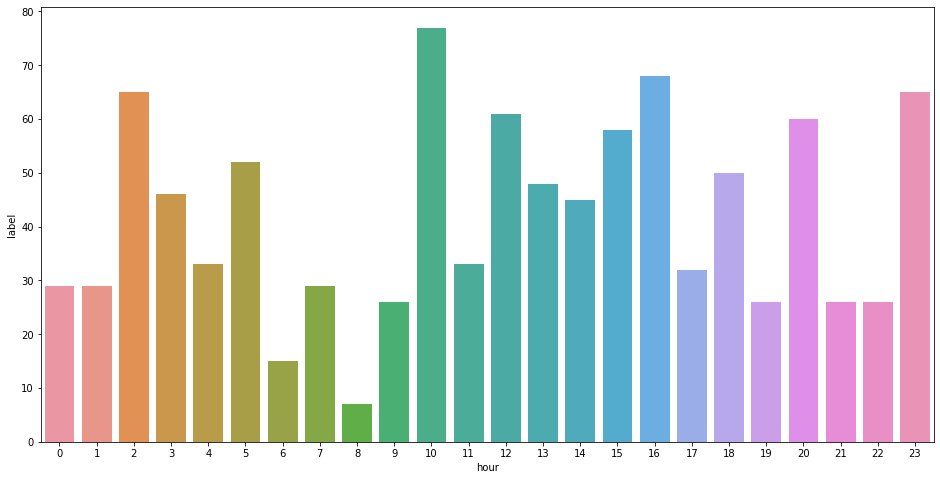

In [15]:
#sns.factorplot(x="hour",data=df[df['label']==1],kind='count',palette='ocean',size=8,aspect=2)
dh = df.groupby('hour')['label'].sum().reset_index()
plt.figure(figsize=(16,8))
sns.barplot(x="hour",y='label', data=dh)
plt.show()

### 时间序列可视化

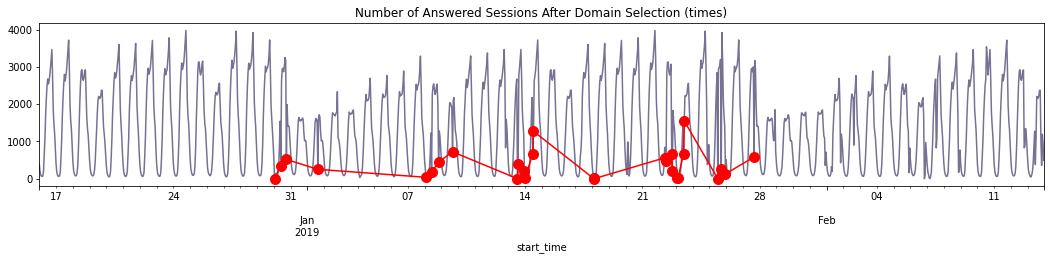

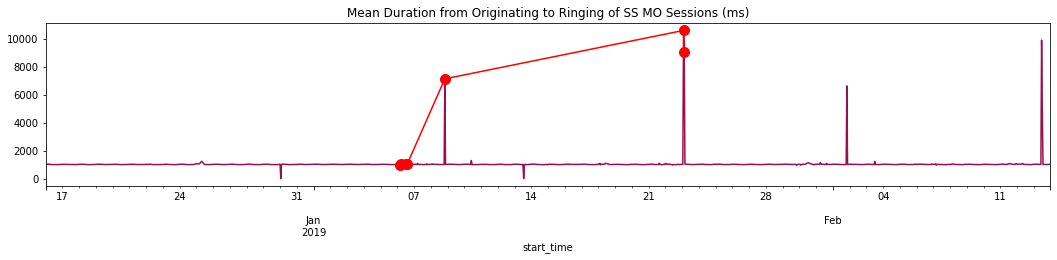

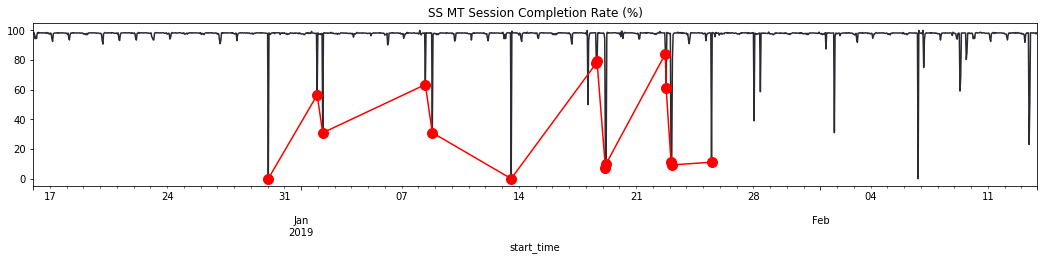

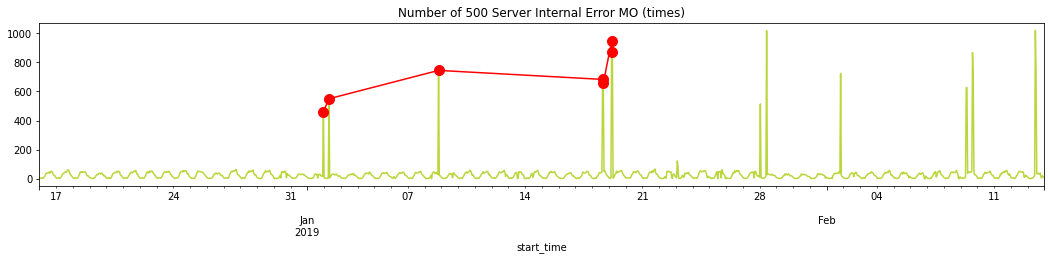

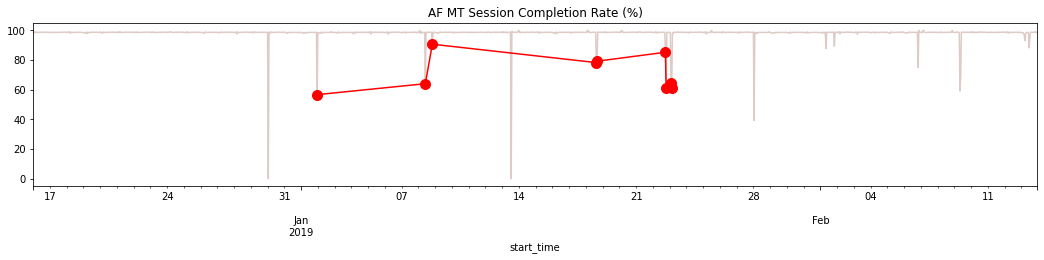

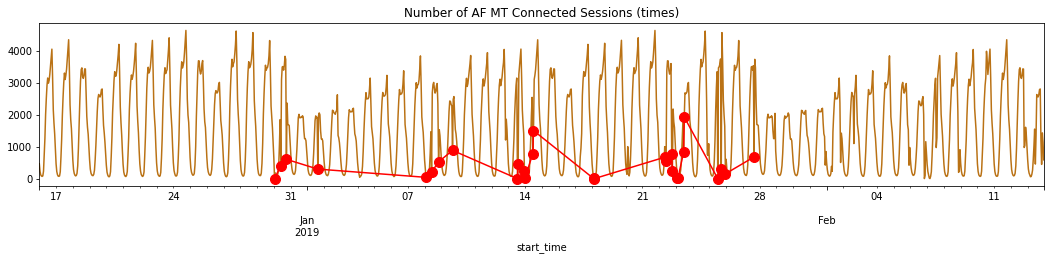

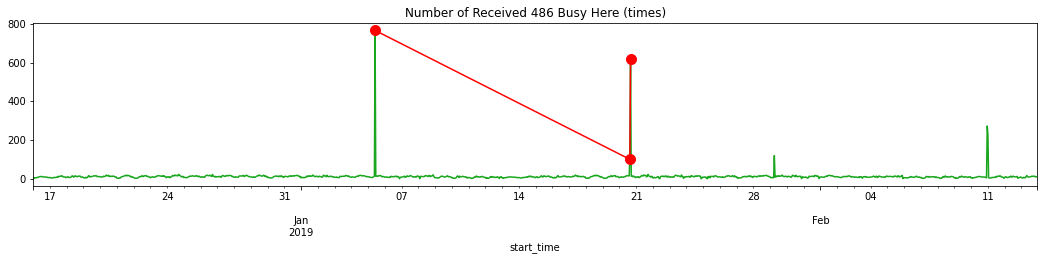

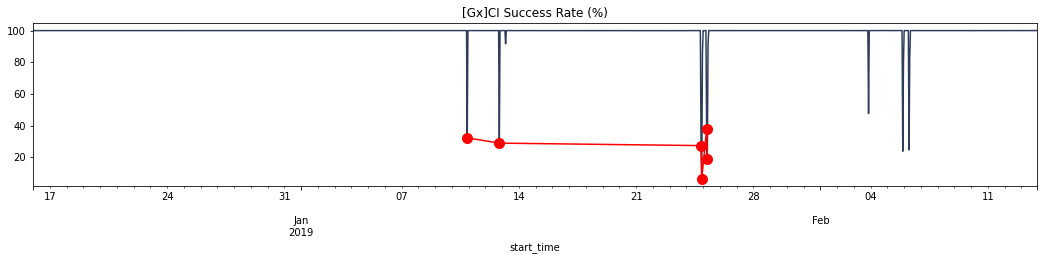

In [12]:
for cc in ['Number of Answered Sessions After Domain Selection (times)',
           'Mean Duration from Originating to Ringing of SS MO Sessions (ms)',
           'SS MT Session Completion Rate (%)',
           'Number of 500 Server Internal Error MO (times)',
           'AF MT Session Completion Rate (%)',
           'Number of AF MT Connected Sessions (times)',
           'Number of Received 486 Busy Here (times)',
           '[Gx]CI Success Rate (%)' ]:
    dd=df[(df['kpi']==cc)]#.iloc[0:672]  #可选择查看全部序列或某一段
    dd.sort_values(['start_time'],inplace=True)
    dd.set_index('start_time',inplace=True)
    anomalies=dd[dd['label']==1]
    
    fig=plt.figure(figsize=(18,3))
    fig=dd['value'].rolling(1).mean().plot(c=np.random.rand(3,))
    fig=anomalies['value'].rolling(1).mean().plot( color='red', marker='o',markersize=10)
    fig=plt.title(cc)

### 训练集合测试集数据分布

In [13]:
df_df = df[df['kpi']=='Number of Answered Sessions After Domain Selection (times)'] 
#  Number of Answered Sessions After Domain Selection (times)
#  [Gx]CI Success Rate (%)

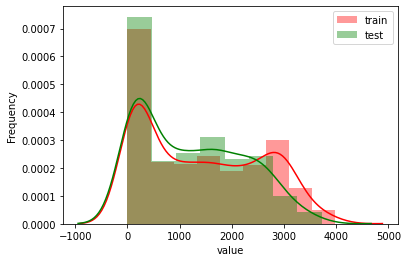

In [14]:
g = sns.distplot(df_df['value'][(df_df["label"].notnull())], color="Red",)
g = sns.distplot(df_df['value'][(df_df["label"].isnull())], ax =g, color="Green")
#g = sns.distplot(df_df[column][(df["label"]==0)], color="Red",)
#g = sns.distplot(df_df[column][(df["label"]==1)], ax =g, color="b")
g.set_xlabel('value')
g.set_ylabel("Frequency")
g = g.legend(["train","test"])
plt.show()

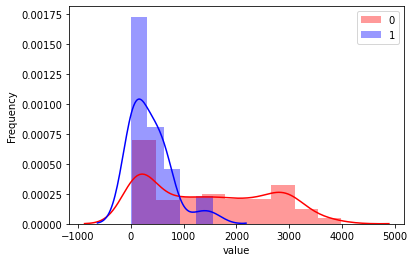

In [15]:
g = sns.distplot(df_df['value'][(df_df["label"]==0)], color="Red",)
g = sns.distplot(df_df['value'][(df_df["label"]==1)], ax =g, color="b")
g.set_xlabel('value')
g.set_ylabel("Frequency")
g = g.legend(["0","1"])
plt.show()

## 特征工程

In [10]:
df.sort_values(['kpi_id','start_time'],inplace=True)

### 统计特征

### 时间特征提取上只使用了历史时间点为特征，避免使用未来时点的时间，

In [11]:
#分组滑动窗口'
cols_win = ['value']
for col in cols_win:
    df['win_2_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=2,min_periods=1).mean().reset_index(0,drop=True)
    
    df['win_3_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=3,min_periods=2).mean().reset_index(0,drop=True)

    df['win_6_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).mean().reset_index(0,drop=True)
    df['win_6_std_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).std().reset_index(0,drop=True)
    df['win_6_skew_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).skew().reset_index(0,drop=True)
    df['win_6_kurt_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).kurt().reset_index(0,drop=True)
    df['win_6_q25_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).quantile(0.25).reset_index(0,drop=True)
    df['win_6_q50_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).quantile(0.50).reset_index(0,drop=True)
    df['win_6_q75_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).quantile(0.75).reset_index(0,drop=True)
    
    df['win_12_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).mean().reset_index(0,drop=True)
    df['win_12_std_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).std().reset_index(0,drop=True)
    df['win_12_skew_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).skew().reset_index(0,drop=True)
    df['win_12_kurt_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).kurt().reset_index(0,drop=True)
    df['win_12_q25_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).quantile(0.25).reset_index(0,drop=True)
    df['win_12_q50_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).quantile(0.50).reset_index(0,drop=True)
    df['win_12_q75_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).quantile(0.75).reset_index(0,drop=True)

### 对比特征

In [12]:
cols_shift=['value','win_2_mean_value','win_3_mean_value']
#计算差分
for col in cols_shift:
    for i in [1,24,48,144,168]:
        cc="shift_{}_{}".format(col,i)
        df[cc] = df.groupby('kpi_id')[col].shift(i)
        df['x_y_{}_{}'.format(col,i)]=np.abs(df[col]-df[cc])
        df['xy_{}_{}'.format(col,i)]=df[col]/df[cc]
        df.drop(cc,axis=1,inplace=True)

### 趋势特征和周期特征

In [13]:
df['expa_mean']=df.groupby(["kpi_id"])['value'].expanding().mean().reset_index(drop=True)
df['expa_std']=df.groupby(["kpi_id"])['value'].expanding().std().reset_index(drop=True)
df['win_3_mean']= df.groupby("kpi_id")['value'].rolling(window=3,min_periods=3).mean().reset_index(0,drop=True)
df['trend_win3']=df['value']-df['win_3_mean']
df['z_score']=(df['win_3_mean']-(df.groupby("kpi_id")['value'].transform('mean')))/df.groupby("kpi_id")['value'].transform('std')

In [173]:
# ont-hot 
#df=pd.get_dummies(df,columns=['kpi'])

In [14]:
#删除较多的缺失值行
df=df[df['x_y_value_168'].notnull()]

In [15]:
train = df[df['label'].notnull()]
test = df[df['label'].isnull()]

In [16]:
train.fillna(0,inplace=True)
test.fillna(0,inplace=True)

In [17]:
test.sort_values('index',inplace=True)

In [18]:
test_pre = test[['index','value','start_time','kpi']]

In [19]:
train.drop(['start_time','kpi','index'],axis=1,inplace=True)
test.drop(['start_time','kpi','index','label'],axis=1,inplace=True)

## 采样

In [51]:
#安装imblearn 包
#!pip install scikit-learn
#!pip install imblearn

    100% |████████████████████████████████| 174kB 19.6MB/s ta 0:00:01
You are using pip version 9.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### 采用了SMOTE的变体SMOTENC 对数据做过采样

In [26]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
#smo = SMOTE(random_state=42)

In [22]:
train[:] = np.nan_to_num(train)
test[:] = np.nan_to_num(test)

In [23]:
train_y = train['label']
train_x = train.drop('label',axis=1)

In [24]:
train_x.head()

,value,weekday,hour,weekend,daylight,kpi_id,win_2_mean_value,win_3_mean_value,win_6_mean_value,win_6_std_value,win_6_skew_value,win_6_kurt_value,win_6_q25_value,win_6_q50_value,win_6_q75_value,win_12_mean_value,win_12_std_value,win_12_skew_value,win_12_kurt_value,win_12_q25_value,win_12_q50_value,win_12_q75_value,x_y_value_1,xy_value_1,x_y_value_24,xy_value_24,x_y_value_48,xy_value_48,x_y_value_144,xy_value_144,x_y_value_168,xy_value_168,x_y_win_2_mean_value_1,xy_win_2_mean_value_1,x_y_win_2_mean_value_24,xy_win_2_mean_value_24,x_y_win_2_mean_value_48,xy_win_2_mean_value_48,x_y_win_2_mean_value_144,xy_win_2_mean_value_144,x_y_win_2_mean_value_168,xy_win_2_mean_value_168,x_y_win_3_mean_value_1,xy_win_3_mean_value_1,x_y_win_3_mean_value_24,xy_win_3_mean_value_24,x_y_win_3_mean_value_48,xy_win_3_mean_value_48,x_y_win_3_mean_value_144,xy_win_3_mean_value_144,x_y_win_3_mean_value_168,xy_win_3_mean_value_168,expa_mean,expa_std,win_3_mean,trend_win3,z_score
81696,41062.0,6.0,0.0,1.0,1.0,0.0,41344.5,41522.000000,41946.500000,561.820167,-0.492438,0.196486,41689.50,42010.5,42258.00,42207.416667,489.034942,-1.258341,1.550799,42077.25,42266.5,42547.75,565.0,0.986427,30.0,0.999270,84.0,0.997958,633.0,0.984818,7346.0,0.848248,407.5,0.990240,54.5,1.001320,234.5,0.994360,488.0,0.988334,7063.5,0.854084,360.666667,0.991389,78.333333,0.998117,292.666667,0.993001,505.333333,0.987976,0.000000,0.000000,9871.130558,454.532862,41522.000000,-460.000000,1.332795
81697,40928.0,6.0,1.0,1.0,1.0,0.0,40995.0,41205.666667,41655.666667,562.182414,-0.345635,-1.821184,41203.25,41752.0,42077.25,42098.333333,612.294393,-0.987645,-0.105631,41814.50,42243.0,42547.75,134.0,0.996737,0.0,1.000000,88.0,0.997854,353.0,0.991449,6529.0,0.862423,349.5,0.991547,15.0,0.999634,86.0,0.997907,493.0,0.988117,6937.5,0.855265,316.333333,0.992382,36.333333,1.000883,185.666667,0.995514,443.000000,0.989363,6726.833333,0.859660,9870.326087,455.070735,41205.666667,-277.666667,1.263093
81698,40915.0,6.0,2.0,1.0,1.0,0.0,40921.5,40968.333333,41425.500000,529.328915,0.337669,-2.180977,40961.50,41344.5,41814.50,41992.083333,699.373415,-0.639919,-1.237153,41485.75,42220.0,42547.75,13.0,0.999682,2.0,1.000049,14.0,1.000342,296.0,0.992817,5857.0,0.874776,73.5,0.998207,1.0,1.000024,37.0,0.999097,324.5,0.992133,6193.0,0.868554,237.333333,0.994240,9.333333,0.999772,52.666667,0.998716,427.333333,0.989677,6577.333333,0.861663,9869.523135,455.605540,40968.333333,-53.333333,1.210799
81699,40846.0,6.0,3.0,1.0,1.0,0.0,40880.5,40896.333333,41209.166667,433.525739,1.001611,-1.077779,40918.25,40995.0,41485.75,41851.250000,748.331978,-0.269897,-1.741423,41028.50,42010.5,42523.00,69.0,0.998314,4.0,1.000098,16.0,1.000392,273.0,0.993361,5327.0,0.884630,41.0,0.998998,3.0,1.000073,15.0,1.000367,284.5,0.993089,5592.0,0.879671,72.000000,0.998243,2.000000,1.000049,19.333333,0.999527,307.333333,0.992541,5904.333333,0.873841,9868.721698,456.137299,40896.333333,-50.333333,1.194934
81700,40800.0,6.0,4.0,1.0,1.0,0.0,40823.0,40853.666667,41029.666667,305.881459,2.015751,4.266029,40863.25,40921.5,41028.50,41702.666667,766.619063,0.080060,-1.829722,40924.75,41752.0,42347.75,46.0,0.998874,5.0,1.000123,2.0,0.999951,286.0,0.993039,3180.0,0.927694,57.5,0.998593,4.5,1.000110,7.0,1.000172,279.5,0.993200,4253.5,0.905638,42.666667,0.998957,3.666667,1.000090,9.333333,1.000229,285.000000,0.993072,4788.000000,0.895096,9867.921772,456.666034,40853.666667,-53.666667,1.185533


In [27]:
smo = SMOTENC(random_state=42,categorical_features=[1,2,3,4,5])

In [28]:
X_smo, y_smo = smo.fit_sample(train_x,train_y)

In [30]:
X_smo.shape

(174244, 57)

In [31]:
train_x=X_smo.reset_index(drop=True)
train_y=y_smo.reset_index(drop=True)


In [35]:
test_x=test.reset_index(drop=True)

## 建模

### XGBoost

In [33]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold,TimeSeriesSplit
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import make_scorer

[0]	test_F1-auc:0.98491
Will train until test_F1-auc hasn't improved in 100 rounds.
[10]	test_F1-auc:0.99446
[20]	test_F1-auc:0.99597
[30]	test_F1-auc:0.99678
[40]	test_F1-auc:0.99736
[50]	test_F1-auc:0.99784
[60]	test_F1-auc:0.99814
[70]	test_F1-auc:0.99851
[80]	test_F1-auc:0.99870
[90]	test_F1-auc:0.99886
[100]	test_F1-auc:0.99899
[110]	test_F1-auc:0.99914
[120]	test_F1-auc:0.99924
[130]	test_F1-auc:0.99936
[140]	test_F1-auc:0.99942
[150]	test_F1-auc:0.99948
[160]	test_F1-auc:0.99953
[170]	test_F1-auc:0.99957
[180]	test_F1-auc:0.99961
[190]	test_F1-auc:0.99964
[200]	test_F1-auc:0.99966
[210]	test_F1-auc:0.99968
[220]	test_F1-auc:0.99972
[230]	test_F1-auc:0.99974
[240]	test_F1-auc:0.99975
[250]	test_F1-auc:0.99977
[260]	test_F1-auc:0.99978
[270]	test_F1-auc:0.99979
[280]	test_F1-auc:0.99980
[290]	test_F1-auc:0.99982
[300]	test_F1-auc:0.99983
[310]	test_F1-auc:0.99984
[320]	test_F1-auc:0.99984
[330]	test_F1-auc:0.99985
[340]	test_F1-auc:0.99986
[350]	test_F1-auc:0.99986
[360]	test_F1-a

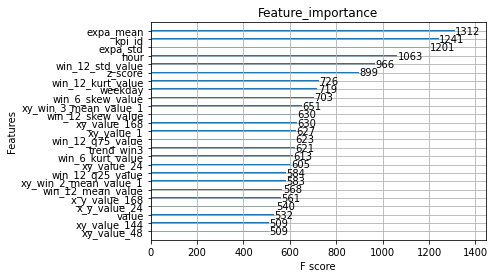

[0]	test_F1-auc:0.98544
Will train until test_F1-auc hasn't improved in 100 rounds.
[10]	test_F1-auc:0.99450
[20]	test_F1-auc:0.99595
[30]	test_F1-auc:0.99667
[40]	test_F1-auc:0.99724
[50]	test_F1-auc:0.99766
[60]	test_F1-auc:0.99799
[70]	test_F1-auc:0.99855
[80]	test_F1-auc:0.99872
[90]	test_F1-auc:0.99892
[100]	test_F1-auc:0.99907
[110]	test_F1-auc:0.99924
[120]	test_F1-auc:0.99935
[130]	test_F1-auc:0.99947
[140]	test_F1-auc:0.99954
[150]	test_F1-auc:0.99961
[160]	test_F1-auc:0.99966
[170]	test_F1-auc:0.99971
[180]	test_F1-auc:0.99974
[190]	test_F1-auc:0.99977
[200]	test_F1-auc:0.99980
[210]	test_F1-auc:0.99982
[220]	test_F1-auc:0.99984
[230]	test_F1-auc:0.99986
[240]	test_F1-auc:0.99987
[250]	test_F1-auc:0.99988
[260]	test_F1-auc:0.99989
[270]	test_F1-auc:0.99989
[280]	test_F1-auc:0.99990
[290]	test_F1-auc:0.99991
[300]	test_F1-auc:0.99992
[310]	test_F1-auc:0.99992
[320]	test_F1-auc:0.99993
[330]	test_F1-auc:0.99993
[340]	test_F1-auc:0.99994
[350]	test_F1-auc:0.99994
[360]	test_F1-a

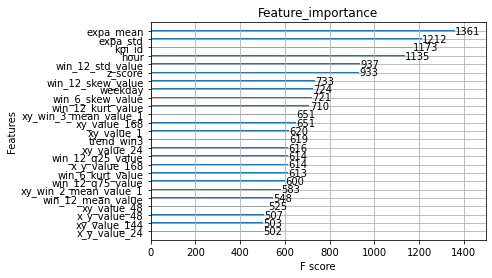

[0]	test_F1-auc:0.98522
Will train until test_F1-auc hasn't improved in 100 rounds.
[10]	test_F1-auc:0.99430
[20]	test_F1-auc:0.99561
[30]	test_F1-auc:0.99641
[40]	test_F1-auc:0.99702
[50]	test_F1-auc:0.99755
[60]	test_F1-auc:0.99786
[70]	test_F1-auc:0.99845
[80]	test_F1-auc:0.99869
[90]	test_F1-auc:0.99891
[100]	test_F1-auc:0.99909
[110]	test_F1-auc:0.99923
[120]	test_F1-auc:0.99934
[130]	test_F1-auc:0.99943
[140]	test_F1-auc:0.99948
[150]	test_F1-auc:0.99953
[160]	test_F1-auc:0.99958
[170]	test_F1-auc:0.99963
[180]	test_F1-auc:0.99967
[190]	test_F1-auc:0.99970
[200]	test_F1-auc:0.99973
[210]	test_F1-auc:0.99975
[220]	test_F1-auc:0.99977
[230]	test_F1-auc:0.99979
[240]	test_F1-auc:0.99981
[250]	test_F1-auc:0.99982
[260]	test_F1-auc:0.99983
[270]	test_F1-auc:0.99985
[280]	test_F1-auc:0.99985
[290]	test_F1-auc:0.99986
[300]	test_F1-auc:0.99986
[310]	test_F1-auc:0.99987
[320]	test_F1-auc:0.99988
[330]	test_F1-auc:0.99989
[340]	test_F1-auc:0.99989
[350]	test_F1-auc:0.99989
[360]	test_F1-a

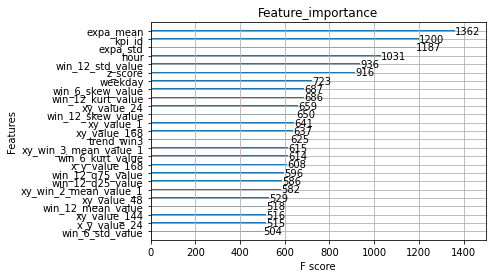

[0]	test_F1-auc:0.98524
Will train until test_F1-auc hasn't improved in 100 rounds.
[10]	test_F1-auc:0.99518
[20]	test_F1-auc:0.99641
[30]	test_F1-auc:0.99729
[40]	test_F1-auc:0.99765
[50]	test_F1-auc:0.99808
[60]	test_F1-auc:0.99837
[70]	test_F1-auc:0.99869
[80]	test_F1-auc:0.99890
[90]	test_F1-auc:0.99904
[100]	test_F1-auc:0.99915
[110]	test_F1-auc:0.99927
[120]	test_F1-auc:0.99941
[130]	test_F1-auc:0.99949
[140]	test_F1-auc:0.99955
[150]	test_F1-auc:0.99958
[160]	test_F1-auc:0.99963
[170]	test_F1-auc:0.99967
[180]	test_F1-auc:0.99970
[190]	test_F1-auc:0.99972
[200]	test_F1-auc:0.99974
[210]	test_F1-auc:0.99976
[220]	test_F1-auc:0.99977
[230]	test_F1-auc:0.99979
[240]	test_F1-auc:0.99980
[250]	test_F1-auc:0.99981
[260]	test_F1-auc:0.99982
[270]	test_F1-auc:0.99982
[280]	test_F1-auc:0.99984
[290]	test_F1-auc:0.99984
[300]	test_F1-auc:0.99985
[310]	test_F1-auc:0.99986
[320]	test_F1-auc:0.99987
[330]	test_F1-auc:0.99988
[340]	test_F1-auc:0.99988
[350]	test_F1-auc:0.99989
[360]	test_F1-a

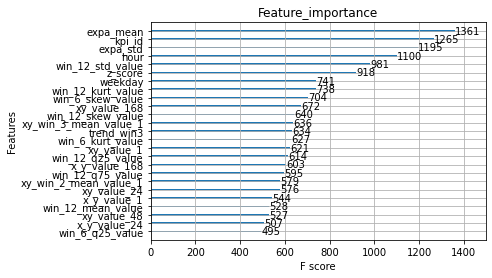

[0]	test_F1-auc:0.98619
Will train until test_F1-auc hasn't improved in 100 rounds.
[10]	test_F1-auc:0.99550
[20]	test_F1-auc:0.99659
[30]	test_F1-auc:0.99719
[40]	test_F1-auc:0.99791
[50]	test_F1-auc:0.99824
[60]	test_F1-auc:0.99843
[70]	test_F1-auc:0.99866
[80]	test_F1-auc:0.99891
[90]	test_F1-auc:0.99902
[100]	test_F1-auc:0.99913
[110]	test_F1-auc:0.99926
[120]	test_F1-auc:0.99937
[130]	test_F1-auc:0.99947
[140]	test_F1-auc:0.99953
[150]	test_F1-auc:0.99959
[160]	test_F1-auc:0.99963
[170]	test_F1-auc:0.99967
[180]	test_F1-auc:0.99971
[190]	test_F1-auc:0.99973
[200]	test_F1-auc:0.99975
[210]	test_F1-auc:0.99977
[220]	test_F1-auc:0.99979
[230]	test_F1-auc:0.99981
[240]	test_F1-auc:0.99983
[250]	test_F1-auc:0.99984
[260]	test_F1-auc:0.99985
[270]	test_F1-auc:0.99986
[280]	test_F1-auc:0.99987
[290]	test_F1-auc:0.99988
[300]	test_F1-auc:0.99988
[310]	test_F1-auc:0.99989
[320]	test_F1-auc:0.99990
[330]	test_F1-auc:0.99990
[340]	test_F1-auc:0.99991
[350]	test_F1-auc:0.99991
[360]	test_F1-a

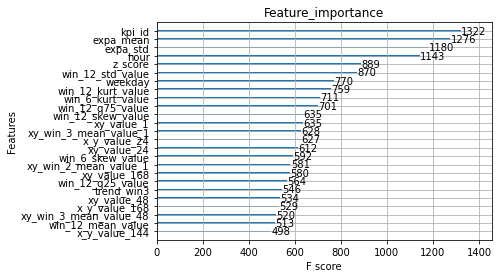

In [38]:
from sklearn.metrics import f1_score
xgb_parrams={
    'booster':'gbtree',
    'objective':'binary:logistic',
    'eval_metric':'auc',
     'colsample_bytree': 0.30801698649621306,
     'gamma': 0.47969503858326235,
     'learning_rate': 0.04341140878653162,
     'max_depth': 7,
     'reg_alpha': 0.38161740307145836,
     'reg_lambda': 0.3109582304218081,
     'subsample': 0.9
            }
def f1_score_vail(pred, data_vail):
    labels = data_vail.get_label()
    score_vail = f1_score(y_true=labels, y_pred=pred, average='binary')      # xgb的predict输出即为对应的label
    return '1-f1_score', 1-score_vail   # xgb目标是将目标指标降低

FOLDS =5   
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

y_preds = np.zeros(test_x.shape[0])
X_test=xgb.DMatrix(test_x)
y_oof = np.zeros(train_x.shape[0])
score_mean = 0

for tr_idx, val_idx in skf.split(train_x, train_y):
    X_tr, X_vl = train_x.iloc[tr_idx, :], train_x.iloc[val_idx, :]
    y_tr, y_vl = train_y.iloc[tr_idx], train_y.iloc[val_idx]

    train_data = xgb.DMatrix(X_tr, y_tr)
    validation_data = xgb.DMatrix(X_vl, y_vl)
    watchlist = [(validation_data, 'test_F1')]
    
    xgb_clf = xgb.train(
                    xgb_parrams,
                    train_data,
                    num_boost_round=600, 
                    early_stopping_rounds=100,
                    #feval=f1_score_vail, 
                    evals=watchlist, 
                    verbose_eval=10,
                    #tree_method='gpu_hist', 
                    )
    X_valid = xgb.DMatrix(X_vl)  # 转为xgb需要的格式
    y_oof[val_idx] = xgb_clf.predict(X_valid)
    #x_score.append(f1_score(y_vl, x_pred, average='binary'))
    
    xgb.plot_importance(xgb_clf, max_num_features=25)
    plt.title("Feature_importance")
    plt.show()
    
    y_preds += xgb_clf.predict(X_test)/FOLDS

In [39]:
test_pre['xgb_preb']=y_preds

### CatBoost

In [40]:
#!pip install catboost
from catboost import  CatBoostClassifier ,Pool

In [64]:
from sklearn.model_selection import StratifiedKFold,GroupKFold

n_fold =5 # amount of data folds
SEED = 2020
#folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=n_fold)

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 50,#200
          'random_seed': SEED
         }
#cat_features=['hour','weekday','kpi']

test_data = Pool(data=test_x,
                 #cat_features=cat_features
                )

scores = []
prediction = np.zeros(test_x.shape[0])
tr_pre = np.zeros(train_x.shape[0])
for fold_n, (train_index, valid_index) in enumerate(gkf.split(train_x,train_y,train_x['kpi_id'])):

    X_train, X_valid = train_x.iloc[train_index],train_x.iloc[valid_index] # train and validation data splits
    y_train, y_valid = train_y[train_index], train_y[valid_index]

    train_data = Pool(data=X_train, 
                      label=y_train,
                      #cat_features=cat_features
                     )
    valid_data = Pool(data=X_valid, 
                      label=y_valid,
                     #cat_features=cat_features
                     )

    model = CatBoostClassifier(**params)
    model.fit(train_data,
              eval_set=valid_data, 
              use_best_model=True
             )

    score = model.get_best_score()['validation']['AUC']#AUC 
    scores.append(score)
    
    cv_data = Pool(data=X_valid)
    tr_pre[valid_index] = model.predict_proba(cv_data)[:,1]

    y_pred = model.predict_proba(test_data)[:, 1]
    prediction += y_pred
prediction /= n_fold
print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))


Learning rate set to 0.107252
0:	test: 0.9625892	best: 0.9625892 (0)	total: 16.1ms	remaining: 16s
50:	test: 0.9959793	best: 0.9959793 (50)	total: 1.9s	remaining: 35.3s
100:	test: 0.9973218	best: 0.9973256 (97)	total: 3.79s	remaining: 33.8s
150:	test: 0.9973753	best: 0.9974669 (134)	total: 5.39s	remaining: 30.3s
200:	test: 0.9975857	best: 0.9975938 (199)	total: 7.65s	remaining: 30.4s
250:	test: 0.9976710	best: 0.9977250 (227)	total: 9.44s	remaining: 28.2s
300:	test: 0.9977976	best: 0.9978030 (299)	total: 11.4s	remaining: 26.6s
350:	test: 0.9979332	best: 0.9979572 (346)	total: 13.3s	remaining: 24.5s
400:	test: 0.9980163	best: 0.9980254 (381)	total: 15.1s	remaining: 22.5s
450:	test: 0.9980517	best: 0.9980686 (409)	total: 16.7s	remaining: 20.3s
500:	test: 0.9980917	best: 0.9981080 (483)	total: 18.1s	remaining: 18s
550:	test: 0.9980649	best: 0.9981211 (530)	total: 19.5s	remaining: 15.9s
600:	test: 0.9980638	best: 0.9981211 (530)	total: 20.7s	remaining: 13.8s
650:	test: 0.9980635	best: 0.998

In [65]:
test_pre['ctb_preb']=prediction

In [66]:
model.get_feature_importance(prettified=True).head(20)

,Feature Id,Importances
0,kpi_id,10.165841
1,hour,5.345089
2,x_y_value_24,4.854008
3,xy_value_24,4.330587
4,x_y_value_168,4.133873
5,expa_std,4.128849
6,expa_mean,3.818981
7,z_score,3.797943
8,win_12_kurt_value,3.440869
9,x_y_value_48,3.317442


### LightGBM

In [67]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.where(y_hat>0.5, 1, 0)#np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True
evals_result = {}

fold 1
Training until validation scores don't improve for 20 rounds
[10]	train's binary_logloss: 0.336102	train's f1: 0.969114	val's binary_logloss: 0.349405	val's f1: 0.94742
[20]	train's binary_logloss: 0.19474	train's f1: 0.975892	val's binary_logloss: 0.215311	val's f1: 0.95667
[30]	train's binary_logloss: 0.124795	train's f1: 0.981033	val's binary_logloss: 0.152248	val's f1: 0.962774
[40]	train's binary_logloss: 0.0872041	train's f1: 0.985275	val's binary_logloss: 0.122184	val's f1: 0.966175
[50]	train's binary_logloss: 0.0648005	train's f1: 0.988279	val's binary_logloss: 0.100682	val's f1: 0.969122
[60]	train's binary_logloss: 0.0509736	train's f1: 0.990492	val's binary_logloss: 0.0903382	val's f1: 0.969623
[70]	train's binary_logloss: 0.0406074	train's f1: 0.991957	val's binary_logloss: 0.0811474	val's f1: 0.97265
[80]	train's binary_logloss: 0.0329624	train's f1: 0.993396	val's binary_logloss: 0.0744787	val's f1: 0.973686
[90]	train's binary_logloss: 0.0274568	train's f1: 0.994

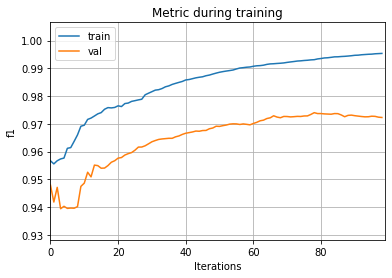

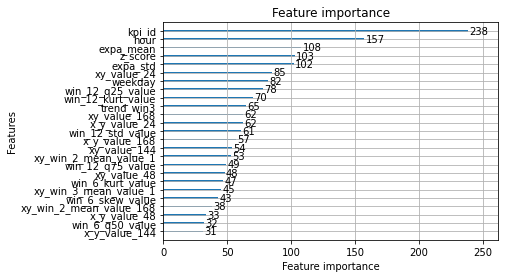

fold 2
Training until validation scores don't improve for 20 rounds
[10]	train's binary_logloss: 0.328322	train's f1: 0.972624	val's binary_logloss: 0.475157	val's f1: 0.805541
[20]	train's binary_logloss: 0.186347	train's f1: 0.97781	val's binary_logloss: 0.437913	val's f1: 0.811857
Early stopping, best iteration is:
[2]	train's binary_logloss: 0.582404	train's f1: 0.96542	val's binary_logloss: 0.616487	val's f1: 0.819734
画特征重要性排序...


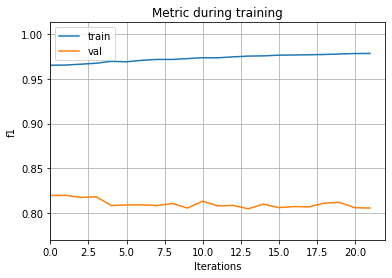

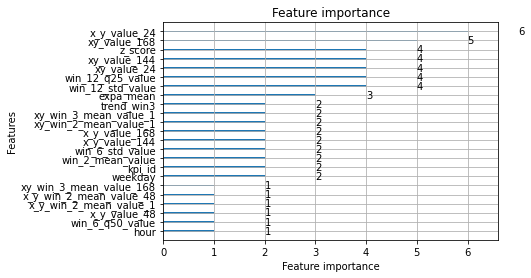

fold 3
Training until validation scores don't improve for 20 rounds
[10]	train's binary_logloss: 0.334821	train's f1: 0.967636	val's binary_logloss: 0.357614	val's f1: 0.936034
[20]	train's binary_logloss: 0.191505	train's f1: 0.97506	val's binary_logloss: 0.232437	val's f1: 0.942547
[30]	train's binary_logloss: 0.120934	train's f1: 0.98083	val's binary_logloss: 0.17991	val's f1: 0.94627
[40]	train's binary_logloss: 0.0830504	train's f1: 0.985926	val's binary_logloss: 0.15175	val's f1: 0.950285
[50]	train's binary_logloss: 0.0610126	train's f1: 0.989198	val's binary_logloss: 0.136191	val's f1: 0.954137
[60]	train's binary_logloss: 0.0465153	train's f1: 0.991422	val's binary_logloss: 0.125895	val's f1: 0.957757
[70]	train's binary_logloss: 0.0367047	train's f1: 0.992776	val's binary_logloss: 0.118388	val's f1: 0.959138
[80]	train's binary_logloss: 0.0297192	train's f1: 0.994104	val's binary_logloss: 0.111455	val's f1: 0.960141
[90]	train's binary_logloss: 0.0243242	train's f1: 0.995095	

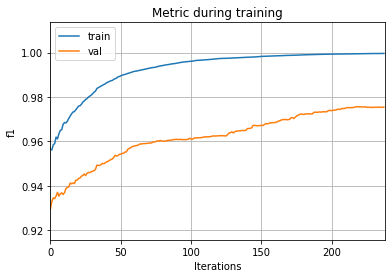

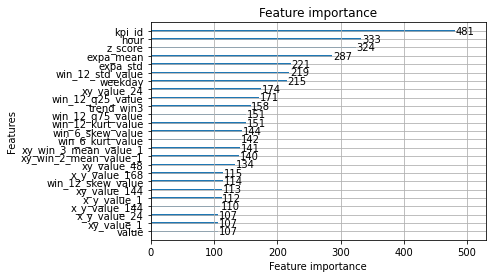

fold 4
Training until validation scores don't improve for 20 rounds
[10]	train's binary_logloss: 0.335953	train's f1: 0.967397	val's binary_logloss: 0.357118	val's f1: 0.942766
[20]	train's binary_logloss: 0.192368	train's f1: 0.977113	val's binary_logloss: 0.229703	val's f1: 0.945138
[30]	train's binary_logloss: 0.121172	train's f1: 0.981987	val's binary_logloss: 0.174549	val's f1: 0.947316
[40]	train's binary_logloss: 0.0829547	train's f1: 0.98635	val's binary_logloss: 0.145224	val's f1: 0.9508
[50]	train's binary_logloss: 0.0599782	train's f1: 0.989304	val's binary_logloss: 0.125676	val's f1: 0.954302
[60]	train's binary_logloss: 0.0457839	train's f1: 0.991567	val's binary_logloss: 0.111033	val's f1: 0.957125
[70]	train's binary_logloss: 0.0357812	train's f1: 0.993099	val's binary_logloss: 0.0983891	val's f1: 0.960687
[80]	train's binary_logloss: 0.0288799	train's f1: 0.994192	val's binary_logloss: 0.0883267	val's f1: 0.963128
[90]	train's binary_logloss: 0.0238794	train's f1: 0.995

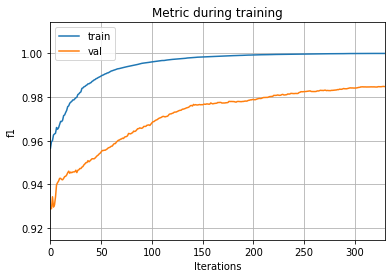

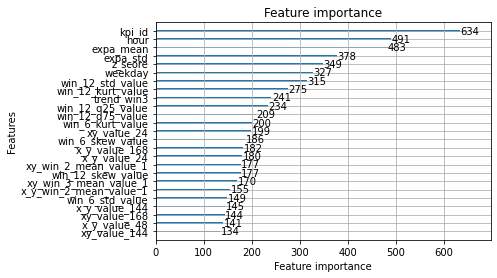

fold 5
Training until validation scores don't improve for 20 rounds
[10]	train's binary_logloss: 0.332954	train's f1: 0.969663	val's binary_logloss: 0.358168	val's f1: 0.941187
[20]	train's binary_logloss: 0.191743	train's f1: 0.977277	val's binary_logloss: 0.228102	val's f1: 0.947971
[30]	train's binary_logloss: 0.121716	train's f1: 0.981681	val's binary_logloss: 0.170079	val's f1: 0.950921
[40]	train's binary_logloss: 0.0831415	train's f1: 0.985669	val's binary_logloss: 0.143911	val's f1: 0.952595
[50]	train's binary_logloss: 0.0610602	train's f1: 0.988692	val's binary_logloss: 0.1296	val's f1: 0.953825
[60]	train's binary_logloss: 0.0467846	train's f1: 0.990992	val's binary_logloss: 0.116901	val's f1: 0.954507
[70]	train's binary_logloss: 0.0372651	train's f1: 0.992702	val's binary_logloss: 0.110923	val's f1: 0.956093
[80]	train's binary_logloss: 0.0302118	train's f1: 0.993924	val's binary_logloss: 0.106487	val's f1: 0.958028
[90]	train's binary_logloss: 0.0248447	train's f1: 0.9950

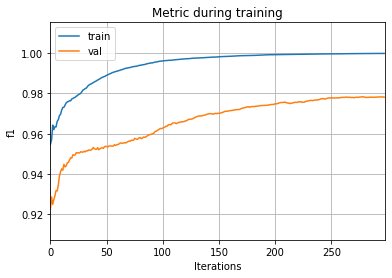

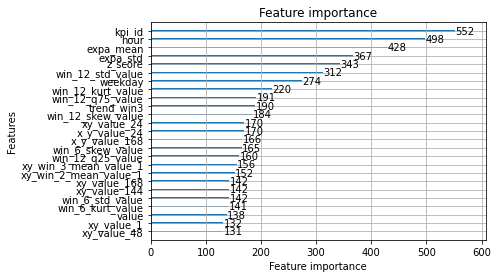

In [68]:
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        #'metric': {'binary_logloss,auc'},
        #'max_depth':-1,
        'num_leaves': 30,
        'learning_rate': 0.07,
        #'min_child_samples':21,
        #'min_child_weight':0.001,
        #'feature_fraction': 0.7,
        #'bagging_fraction': 0.6,
        #'bagging_freq': 2,
        #'min_split_gain':0.5,
        'verbose': 0,
        #'is_unbalenced':True,
    }

test_pred_prob = np.zeros((test_x.shape[0], ))
    
n_fold=5
#folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=SEED)
gkf = GroupKFold(n_splits=n_fold)
toof = np.zeros((train_x.shape[0], ))
for fold_, (trn_idx, val_idx) in enumerate(gkf.split(train_x,train_y,train_x['kpi_id'])):
    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y.iloc[trn_idx])
    val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y.iloc[val_idx])

    clf = lgb.train(params,
                    trn_data,
                    valid_sets=[trn_data, val_data],
                    valid_names=['train', 'val'],
                    feval=lgb_f1_score,
                    evals_result=evals_result,
                    verbose_eval=10,
                    #categorical_feature=[],
                    early_stopping_rounds=20,
                    num_boost_round = 10000
                    )
    lgb.plot_metric(evals_result, metric='f1')
    toof[val_idx] = clf.predict(train_x.iloc[val_idx], num_iteration=clf.best_iteration)

    #precisions,recalls,thresholds=precision_recall_curve(train_y.iloc[val_idx],toof[val_idx] )
    #plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

    test_pred_prob += clf.predict(test_x, num_iteration=clf.best_iteration) / gkf.n_splits
    print('画特征重要性排序...')
    ax = lgb.plot_importance(clf, max_num_features=25)#max_features表示最多展示出前10个重要性特征，可以自行设置
    plt.show()

In [48]:
test_pre['lgb_preb']=test_pred_prob

### 模型融合 采用了线性加权的融合方式

In [49]:
test_pre.head()

,index,value,start_time,kpi,xgb_preb,ctb_preb,lgb_preb
105264,0,794.0,2019-01-28 00:00:00,Number of Answered Sessions After Domain Selec...,0.000378,0.000364,0.000710
105265,1,400.0,2019-01-28 01:00:00,Number of Answered Sessions After Domain Selec...,0.000259,0.000482,0.000432
105266,2,247.0,2019-01-28 02:00:00,Number of Answered Sessions After Domain Selec...,0.000395,0.001681,0.001031
105267,3,156.0,2019-01-28 03:00:00,Number of Answered Sessions After Domain Selec...,0.001060,0.002192,0.002041
105268,4,120.0,2019-01-28 04:00:00,Number of Answered Sessions After Domain Selec...,0.000787,0.004242,0.001330


In [50]:
test_pre['preb']=test_pre['lgb_preb']*0.3+test_pre['xgb_preb']*0.4+test_pre['ctb_preb']*0.3

## 异常值召回

In [ ]:
#可以适当调整一下阈值，即可上分

In [58]:
test_pre['label']=test_pre.apply(lambda row : 1 if row['preb'] >=0.55 else 0,axis=1)

In [59]:
sub=test_pre[['start_time','kpi','label']]

In [60]:
sub['label'].sum()

656

In [61]:
sub.head()

,start_time,kpi,label
105264,2019-01-28 00:00:00,Number of Answered Sessions After Domain Selec...,0
105265,2019-01-28 01:00:00,Number of Answered Sessions After Domain Selec...,0
105266,2019-01-28 02:00:00,Number of Answered Sessions After Domain Selec...,0
105267,2019-01-28 03:00:00,Number of Answered Sessions After Domain Selec...,0
105268,2019-01-28 04:00:00,Number of Answered Sessions After Domain Selec...,0


In [62]:
from naie.feature_processing import data_flow
data = data_flow.create_dataflow_from_df(sub)

## 生成数据实例

可以先在【数据集】模块新建一个“Dataset”数据集

In [63]:
#@param_dict {"id":"create-dataset"}
create_dataset_kwargs = {
    "dataset": "Dataset",
    "dataset_entity": "sub"
}
current_dataflow = data #@param {"id":"default.current_dataflow"}
current_dataflow.write_as_dataset(**create_dataset_kwargs)

resolve path s3://bucket-ebe3fox4/0548d3aef88010d81fe5c01705849a10/ceba8dd9005f4849a86773743085160b/Dataset Dataset sub.
resolve path s3://bucket-ebe3fox4/0548d3aef88010d81fe5c01705849a10/ceba8dd9005f4849a86773743085160b/Dataset Dataset sub.
